In [1]:
from dolfin import *
import numpy as np
import pygad
from pyswarm import pso
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

set_log_level(LogLevel.WARNING)

In [2]:
# 参数准备
nelx, nely = 10, 10
# 二维正交各向异性
E1, E2, mu12, G12 = 130000, 7700, 0.33, 4800
# 转动角度
Theta = 0
Theta_init = 5
# 载荷
forcing = Constant((500, 0))

In [3]:
# 弹性张量
C2D_Iso = np.array([
    [E1/(1-mu12**2),        mu12*E2/(1-mu12**2),         0  ],
    [mu12*E2/(1-mu12**2),   E2/(1-mu12**2),              0  ],
    [0,                     0,                           G12]
])

# 转轴公式
def T2D_inv(theta):
    theta = theta * np.pi / 180.0
    c = cos(theta)
    s = sin(theta)
    Trans = np.array([
        [c**2,  s**2,   -2*s*c],
        [s**2,  c**2,   2*s*c],
        [s*c,   -s*c,   c**2 - s**2]
    ])
    # Trans = np.array([
    #     [np.cos(theta)**2, np.sin(theta)**2, -2*np.sin(theta)*np.cos(theta)],
    #     [np.sin(theta)**2, np.cos(theta)**2, 2*np.sin(theta)*np.cos(theta)],
    #     [np.sin(theta)*np.cos(theta), -np.sin(theta)*np.cos(theta), np.cos(theta)**2-np.sin(theta)**2]
    # ])
    return Trans

In [4]:
# 模型准备
mesh = UnitSquareMesh(nelx, nely)
V = VectorFunctionSpace(mesh, "CG", 1)
T = FunctionSpace(mesh, "DG", 0)
u_sol = Function(V)
Theta_sol = Function(T)
# v = Function(T)
# v.vector()[:] = 1
u_trial = TrialFunction(V)
v_test = TestFunction(V)

In [5]:
# 物理方程
def epsilon(u):
    engineering_strain = 0.5 * (nabla_grad(u) + nabla_grad(u).T)
    return engineering_strain

# 本构方程
def sigma_tensor(u, Theta_Ev):
    # 计算应变张量
    epsilon_ij = epsilon(u)
    ep = as_vector([epsilon_ij[0,0], epsilon_ij[1,1], epsilon_ij[0,1]])
    # 使用弹性系数计算应力张量
    Q_bar = np.dot(np.dot(T2D_inv(Theta_Ev), C2D_Iso), T2D_inv(Theta_Ev).T)
    sigma_ij = np.dot(Q_bar, ep)

    return as_tensor([[sigma_ij[0], sigma_ij[2]],
                      [sigma_ij[2], sigma_ij[1]]])

# 弹性能密度
def psi(u, Theta):
    return 0.5 * inner(sigma_tensor(u, Theta), epsilon(u))

In [6]:
# 边界定义
# 狄利克雷边界
def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < DOLFIN_EPS

bc = DirichletBC(V, Constant((0.0, 0.0)), clamped_boundary)

# 自然边界
class RightEnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 1) < DOLFIN_EPS and (abs(x[1] - 0.5) < 0.5)
right_end_boundary = RightEnd()

class TopEnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 0.5) < 0.1 and (abs(x[1] - 1) < DOLFIN_EPS)
top_end_boundary = TopEnd()

boundary_mark = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundary_mark.set_all(0)
right_end_boundary.mark(boundary_mark, 1)
top_end_boundary.mark(boundary_mark, 2)

In [7]:
# 有限元求解
def FEA(V:VectorFunctionSpace, lhs, rhs, u:Function, bc:DirichletBC) -> Function: 
    problem = LinearVariationalProblem(lhs, rhs, u, bc)
    solver = LinearVariationalSolver(problem)
    return solver.solve()

Stopping search: maximum iterations reached --> 100


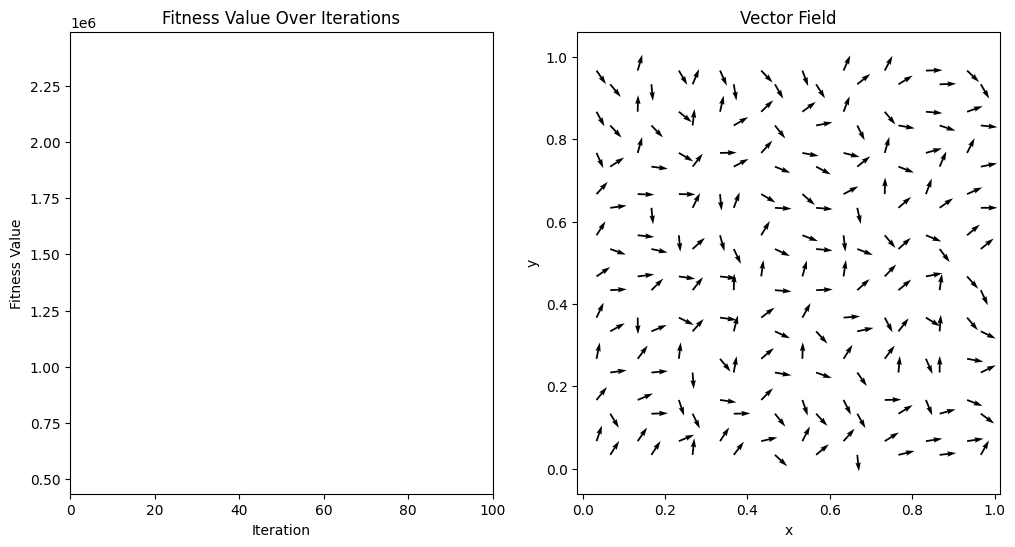

Best Solution: [ 1.92674868e+01 -5.48838204e-01  3.50684499e+00 -1.53468586e+00
 -1.10380975e+01  3.74807129e+01 -1.76898906e+01 -3.12110308e+01
  2.22937642e+01 -4.11955812e+00  7.02395506e+00 -1.39328031e+01
  1.14155873e+01  4.12594288e+00  2.39815248e+01 -3.75586401e+01
 -2.17246087e+01  3.87422092e+01  5.95931252e+01 -5.10332175e+00
  3.78103887e+01 -2.47939512e+01 -2.69584763e+01  2.46670579e+01
  2.01804300e+01  4.21287723e+01 -1.60267746e+01 -3.19304379e+00
  4.97551743e+01 -2.62564777e+01  4.52287330e+01  1.40481147e+00
 -3.19909086e+01  1.46738316e+01  1.24604035e+01 -2.11132014e+01
 -6.90402675e+01 -4.01794366e+00 -4.95630001e+00 -3.86407935e+01
  1.08634440e+01  3.90937040e+01  3.23369624e+01  2.12898252e+01
  4.27988911e+01  3.30111912e+01 -2.56641710e+01 -3.34800911e+01
 -4.55960828e+01  4.75668644e+01 -1.80505989e+01 -1.93215581e+01
  2.57901812e+01 -4.51442150e+01 -1.20958777e+01  5.14073704e+01
  3.62327107e+01 -1.81632666e+01 -3.00308544e+01 -3.95279828e+01
  2.894953

In [8]:
# 适应度函数
energy = []
fitness_history = []
theta_values_history = []

def fitness_func(solution):
    theta_values = solution.reshape(T.dim())
    # theta_values = np.clip(theta_values, -90, 90)
    theta_func = Function(T)
    theta_func.vector()[:] = theta_values
    Theta_sol.assign(theta_func)
    lhs = inner(sigma_tensor(u_trial, Theta_sol), nabla_grad(v_test)) * dx
    rhs = dot(forcing, v_test) * ds(subdomain_data=boundary_mark, domain=mesh, subdomain_id=1)
    FEA(V, lhs, rhs, u_sol, bc)
    energy_density = assemble(psi(u_sol, Theta_sol) * dx)
    energy.append(energy_density)
    
    # 添加平滑惩罚项
    smoothness_penalty = 0
    for cell in cells(mesh):
        cell_index = cell.index()
        cell_theta = theta_values[cell_index]
        for facet in facets(cell):
            neighbor_cells = facet.entities(2)
            for neighbor in neighbor_cells:
                if neighbor < T.dim() and neighbor != cell_index:
                    neighbor_theta = theta_values[neighbor]
                    angle_diff = cell_theta - neighbor_theta
                    smoothness_penalty += angle_diff ** 2

    smoothness_penalty /= mesh.num_cells()  # 归一化

    fitness = energy_density + 100 * smoothness_penalty
    fitness_history.append(fitness)  # 记录每次评估的适应度值
    theta_values_history.append(theta_values.copy())
    return fitness
    


best_fitness_values = []
def on_generation(ga_instance):
    best_fitness_values.append(-ga_instance.best_solution()[1])
    print(f"Generation {ga_instance.generations_completed}: Best Fitness = {-ga_instance.best_solution()[1]}")
    return

# 设置PSO参数
lb = [-90] * T.dim()
ub = [90] * T.dim()
swarm_size = 50
max_iter = 100

# 运行PSO
best_solution, best_fitness = pso(fitness_func, lb, ub, swarmsize=swarm_size, maxiter=max_iter)

# 动画展示
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# 初始化适应度值变化图
line1, = ax1.plot([], [], 'b-')
ax1.set_xlim(0, max_iter)
ax1.set_ylim(min(fitness_history), max(fitness_history))
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Fitness Value")
ax1.set_title("Fitness Value Over Iterations")

# 初始化向量场图
theta_rad = np.deg2rad(theta_values_history[0])
x_values = np.cos(theta_rad)
y_values = np.sin(theta_rad)
vector_values = np.vstack((x_values, y_values)).T
cell_midpoints = [cell.midpoint() for cell in cells(mesh)]
x_coords = np.array([p.x() for p in cell_midpoints])
y_coords = np.array([p.y() for p in cell_midpoints])
u = vector_values[:, 0]
v = vector_values[:, 1]
quiver = ax2.quiver(x_coords, y_coords, u, v)
ax2.set_title("Vector Field")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.axis("equal")

def init():
    line1.set_data([], [])
    quiver.set_UVC(u, v)
    return line1, quiver

def update(frame):
    line1.set_data(range(frame+1), fitness_history[:frame+1])
    
    theta_rad = np.deg2rad(theta_values_history[frame])
    x_values = np.cos(theta_rad)
    y_values = np.sin(theta_rad)
    vector_values = np.vstack((x_values, y_values)).T
    u = vector_values[:, 0]
    v = vector_values[:, 1]
    quiver.set_UVC(u, v)
    
    return line1, quiver

ani = FuncAnimation(fig, update, frames=range(max_iter), init_func=init, blit=True, repeat=False)
plt.show()

print(f"Best Solution: {best_solution}")
print(f"Best Fitness: {best_fitness}")

In [9]:
# 应变能
# # 遗传算法参数
# num_genes = T.dim()  
# initial_population = np.random.uniform(low=-90, high=90, size=(50, num_genes))

# ga_instance = pygad.GA(
#     num_generations=200,
#     num_parents_mating=5,
#     fitness_func=fitness_func,
#     sol_per_pop=10,
#     num_genes=num_genes,
#     initial_population=initial_population,
#     mutation_percent_genes=10,
#     on_generation=on_generation
# )


# # 运行遗传算法
# ga_instance.run()

# 设置PSO参数
lb = [-90] * T.dim()
ub = [90] * T.dim()
swarm_size = 50
max_iter = 100

# 运行PSO
best_solution, best_fitness = pso(fitness_func, lb, ub, swarmsize=swarm_size, maxiter=max_iter)


# import matplotlib.pyplot as plt
# # 绘制适应度值变化曲线
# plt.plot(fitness_history)
# plt.xlabel("Generation")
# plt.ylabel("Best Fitness Value")
# plt.title("Best Fitness Value Change Over Generations")
# plt.show()

Stopping search: maximum iterations reached --> 100


In [10]:
def plot_theta_vector(theta:Function, mesh):
    theta_rad = np.deg2rad(Theta_sol.vector()[:])  # 将角度转换为弧度
    x_values = np.cos(theta_rad)
    y_values = np.sin(theta_rad)
    # 将二维向量表示合并为一个二维数组
    vector_values = np.vstack((x_values, y_values)).T  # 转置使每行是一个向量
    # 获取网格的中心点
    cell_midpoints = [cell.midpoint() for cell in cells(mesh)]
    # 提取中心点的坐标
    x_coords = np.array([p.x() for p in cell_midpoints])
    y_coords = np.array([p.y() for p in cell_midpoints])
    u = vector_values[:, 0]
    v = vector_values[:, 1]
    # 可视化向量场
    plt.figure()
    plot(mesh)
    plt.quiver(x_coords, y_coords, u, v)
    plt.title("Vector field")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.show()

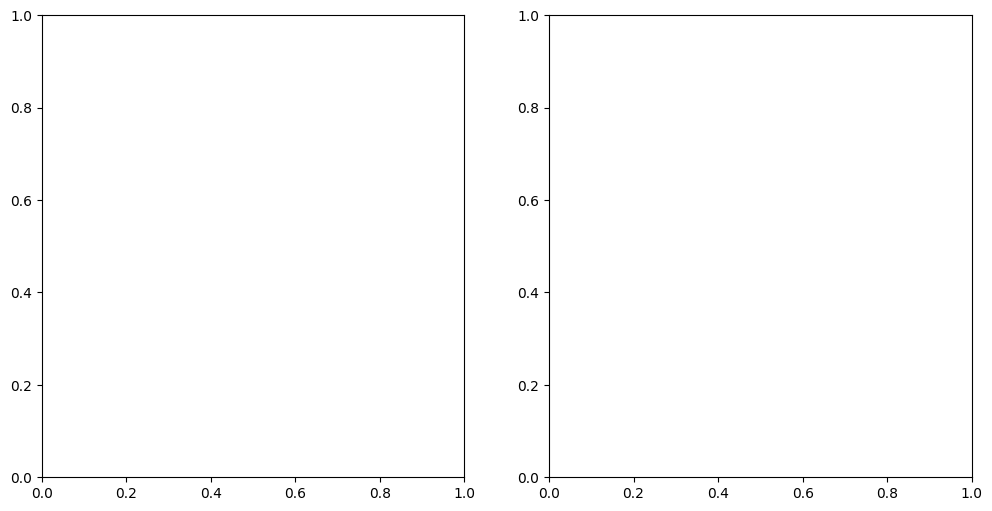

In [11]:

# plot_theta_vector(Theta_sol, mesh)

# 实时绘制函数
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
def animate(i):
    ax[0].clear()
    ax[1].clear()
    ax[0].plot(fitness_history)
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("Fitness Value")
    ax[0].set_title("Fitness Value Change Over Iterations")
    plot_theta_vector(ax[1], Theta_sol)

ani = FuncAnimation(fig, animate, frames=max_iter, interval=200)

plt.show()